In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [3]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [4]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

### Visualize models from posterior distribution

In [5]:
model = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles_replicate.pkl','rb'))

In [6]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['rae'],color='#1f78b4',zorder=0)

    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [7]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [8]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

0.0018241406250000005


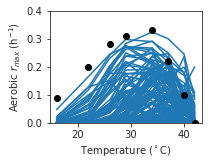

In [9]:
plot_lines_prior_ae(model,outname='../figures/aerobic_prior_lines.pdf')

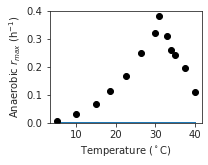

In [11]:
plot_lines_prior_an(model,outname='../figures/anaerobic_prior_lines.pdf')

4.260765416666666
127


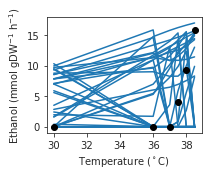

In [13]:
plot_lines_prior_chemostat(model,prefix='../figures/chemostat_prior_lines')

In [14]:
!pwd

/home/jakobpp/BayesianGEM/code


In [15]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [16]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [17]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [18]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

0.0018241406250000005


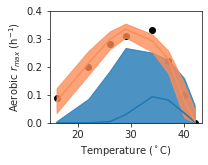

In [19]:
plot_last_population_ae(model,outname='../figures/aerobic_prior_posterior.pdf')

0.0017126156249999997


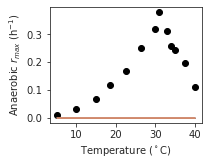

In [20]:
plot_last_population_an(model,outname='../figures/anaerobic_prior_posterior.pdf')

4.260765416666666


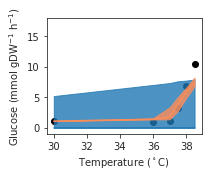

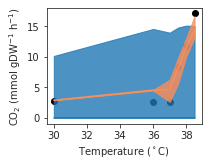

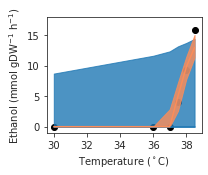

In [21]:
plot_last_population_chemostat(model,prefix='../figures/chemostat_prior_posterior')

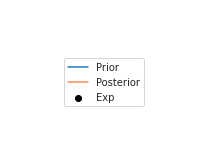

In [22]:
 plot_legend_growth()

### Visualize particle population

In [23]:
def build_a_dataframe_for_all_particles(results):
    columns = list(results.all_particles[0].keys())
    columns.sort()

    data = list()
    for p in results.all_particles:
        data.append([p[k] for k in columns])
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]
    df = df.loc[sel_index,:]
    print(df.shape)

    return df

In [24]:
def perform_pca_on_parameters(df):
    # 1. normalize all columns to a standard normal distribution
    X, y = df.values[:,:-1], df.values[:,-1]
    X_n = np.zeros_like(X)
    
    for i in range(X_n.shape[1]): X_n[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    pca = PCA(n_components=2)
    PCS = pca.fit_transform(X_n)
    print(pca.explained_variance_ratio_)
    return PCS,pca.explained_variance_ratio_

In [25]:
df_theta = build_a_dataframe_for_all_particles(model)

(27997, 2293)
(27969, 2293)


In [26]:
PCS,EV = perform_pca_on_parameters(df_theta)

[0.01003077 0.00315742]


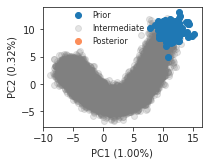

In [27]:
y = df_theta.values[:,-1]
plt.figure(figsize=(3.,2.4))

plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
plt.scatter(PCS[:128,0],PCS[:128,1],color='#1f78b4',label='Prior')
plt.scatter([],[],color='grey',alpha=0.2,label='Intermediate')
plt.scatter(PCS[y>0.9,0],PCS[y>0.9,1],color='#fc8d59',label='Posterior')

plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
plt.xticks(np.arange(-10,20,5))
plt.tight_layout()
#plt.savefig('../figures/pca.pdf')
plt.savefig('../figures/pca.png',dpi=300)
plt.show()

## How close were the simulated results to the reference

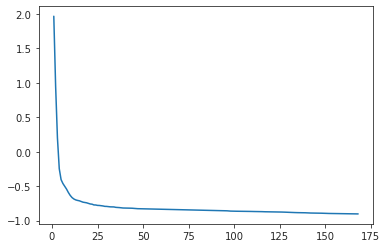

In [38]:
plt.figure()
plt.plot(model.epsilons)

In [53]:
np.nonzero(np.array(model.epsilons) < -0.5)[0].min()

7

In [64]:
model.simu

-0.7904086188708653

In [ ]:
?

### Train a surrogate model to identify the most important parameters

/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


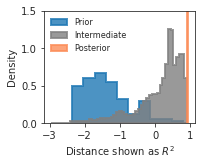

In [129]:
plt.figure(figsize=(3,2.4))
hist_kws = {"histtype": "stepfilled", "linewidth": 2,"alpha": 0.8}
hist_kws['edgecolor'] = '#1f78b4'
sns.distplot(y[:128],kde=False,norm_hist=True,hist_kws=hist_kws,color='#1f78b4',label='Prior')

hist_kws['edgecolor'] = 'grey'
sns.distplot(y[128:][y[128:]<0.9],kde=False,norm_hist=True,hist_kws=hist_kws,color='grey',label='Intermediate')

hist_kws['edgecolor'] = '#fc8d59'
sns.distplot(y[y>0.9],kde=False,norm_hist=True,hist_kws=hist_kws,bins=20,color='#fc8d59',label='Posterior')
plt.ylim([0,1.5])
plt.xlabel('Distance shown as $R^2$')
plt.ylabel('Density')
plt.legend(fontsize=8,frameon=False)
plt.tight_layout()
plt.savefig('../figures/distance.pdf')
plt.show()

In [12]:
df_feature_score = pd.read_csv('../results/machine_learning_feature_importance.csv',index_col=0)
print(df_feature_score.shape)

(2292, 2)


In [13]:
df_feature_score.head(n=5)

,importance,std
feature,,
O13525_Tm,0.000272,0.000496
O13525_Topt,0.000478,0.001033
O13525_dCpt,0.000254,0.000440
P00044_Tm,0.000265,0.000468
P00044_Topt,0.000590,0.000992


In [21]:
def plot_top_n_features(df,n=10,barh=True):
    # 1. sort all samples based on mean score from biggest to smallest
    cs = {'Topt':'#1b9e77', 'Tm':'#d95f02', 'dCpt':'#7570b3'}
    sorted_index = list(df.index[np.argsort(df['importance'])])
    #sorted_index.reverse()
    
    df = df.loc[sorted_index,:]
    gene_names,gene_ids = load_gene_names()
    
    ticks = [name.replace(name.split('_')[0],gene_names[name.split('_')[0]]) for name in df.index[-n:]]
    ticks = [item.replace('Topt','$T_{opt}$').replace('Tm','$T_m$') for item in ticks]
    # 2. plot a bar chart
    if barh:
        plt.figure(figsize=(3,5.5))
        plt.barh(np.arange(n),
                 df['importance'].values[-n:],
                 xerr=df['std'].values[-n:],
                 color =[cs[item.split('_')[-1]] for item in ticks],
                 capsize=4)
        plt.yticks(np.arange(n),ticks,fontsize=10)
        plt.ylim((-0.5,len(ticks)-0.5))
        plt.xlabel('Importance score')
        plt.xticks(np.arange(0,0.04,0.01))
    else:
        plt.figure(figsize=(8.8,2.5))
        plt.bar(-np.arange(n),
                 df['importance'].values[-n:],
                 yerr=df['std'].values[-n:],
                 color ='gray',
                 capsize=4)
        plt.xticks(-np.arange(n),ticks,fontsize=10,rotation=45,ha='right')
        #plt.xlim((-0.5,len(ticks)-0.5))
        plt.ylabel('Importance score')
        plt.yticks(np.arange(0,0.04,0.01))
    
    plt.tight_layout()
    plt.savefig('../figures/top_n_feature_importance_barv.pdf')
    plt.show()

In [10]:
def plot_accumulated_three_types(df):
    # 1. sort all samples based on mean score from biggest to smallest
    plt.figure(figsize=(3.,2.4))
    sorted_index = list(df.index[np.argsort(df['importance'])])
    sorted_index.reverse()
    df = df.loc[sorted_index,:]
    
    # {'Tm':[0,0.02,0,0,],'dCpt':[],'Topt':[]}
    data = {'Tm':np.zeros(len(sorted_index)),
            'Topt':np.zeros(len(sorted_index)),
            'dCpt':np.zeros(len(sorted_index))}
    
    labl_pos = {'Tm':(1000,0.23), 'Topt':(500,0.35),'dCpt':(2000,0.16)}
    labls = {'Tm':'$T_m$', 'Topt':'$T_{opt}$','dCpt':'$\Delta$$C_{pt}$'}
    #cs = {'Topt':'#1b9e77', 'Tm':'#d95f02', 'dCpt':'#7570b3'}
    
    for i,name in enumerate(sorted_index):
        tpe = name.split('_')[-1]
        data[tpe][i] = df.loc[name,'importance']
    
    for tpe,lst in data.items():
        plt.plot(np.arange(len(lst)),np.cumsum(lst),label=tpe,color='k') #
        #plt.text(labl_pos[tpe][0],labl_pos[tpe][1],labls[tpe],ha='center',va='center') #,color=cs[tpe]
    #plt.legend(loc='upper left',frameon=False,fontsize=8,ncol=2,columnspacing=0.3)
    
    plt.xlabel('Number of features')
    plt.ylabel('Accumulated\n importance score')
    plt.yticks(np.arange(0,0.6,0.1))
    plt.tight_layout()
    plt.savefig('../figures/accumulated_feature_importance.pdf')
    plt.show()

In [204]:
?plt.legend

In [54]:
x = [1,0,1,2,0,0,1]
np.cumsum(x)

array([1, 1, 2, 4, 4, 4, 5])

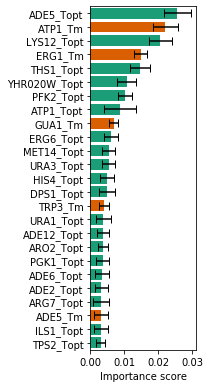

In [70]:
plot_top_n_features(df_feature_score,n=25)

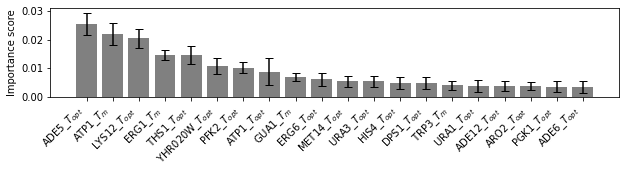

In [22]:
plot_top_n_features(df_feature_score,n=20,barh=False)

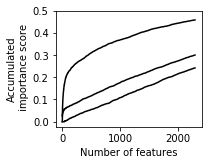

In [11]:
 plot_accumulated_three_types(df_feature_score)

#### Plot an example for the reduction of uncertainty

In [7]:
def f_test(x1,x2):
    F = np.var(x1)/np.var(x2)
    p = stats.f.cdf(F,len(x1)-1,len(x2)-1)
    return 1-p

In [15]:
def plot_param_dist_prior_posterior(model,uniprot,save=False,figsize=None):
    x1, x2 = [], [] # [[Tms],[Topts],[dCpts]]
    for p in model.population_t0:
        x1.append([p['{0}_Tm'.format(uniprot)]-273.15,
                   p['{0}_Topt'.format(uniprot)]-273.15,
                   p['{0}_dCpt'.format(uniprot)]/1000])
    
    for p in model.population:
        x2.append([p['{0}_Tm'.format(uniprot)]-273.15,
                   p['{0}_Topt'.format(uniprot)]-273.15,
                   p['{0}_dCpt'.format(uniprot)]/1000])
    x1 = np.array(x1)
    x2 = np.array(x2)
    
    #print(x1)
    #print(x2)
    xlabels = ['$T_m$ ($^\circ$C)','$T_{opt}$ ($^\circ$C)','$\Delta$$C_{pt}$ (kJ/mol/K)']
    if figsize is None: plt.figure(figsize=(8.74,2.4))
    else: plt.figure(figsize=figsize)
    for i in range(3):
        #print('ttest:',ttest(x1[:,i],x2[:,i])[1])
        #print('ftest:',f_test(x1[:,i],x2[:,i]))
        #print('')
        plt.subplot(1,3,i+1)
        #sns.kdeplot(x1[:,i], shade=True,label='Prior')
        #sns.kdeplot(x2[:,i], shade=True,label='Posterior')
        hist_kws = {"histtype": "stepfilled", "linewidth": 2,"alpha": 0.8, 'edgecolor':'k'}
        sns.distplot(x1[:,i],label='Prior',kde=False,hist_kws=hist_kws,bins=20)
        sns.distplot(x2[:,i],label='Posterior',kde=False,hist_kws=hist_kws,bins=20)
        plt.xlabel(xlabels[i])
        plt.ylabel('Density')
        if i==0: plt.legend()
    plt.tight_layout()
    if save:plt.savefig('../figures/parameter_prio_pos_{0}.pdf'.format(uniprot))
    plt.show()

In [16]:
def plot_scatter_compare_two(model,uniprot):
    x = [] # [[Tms],[Topts],[dCpts]] 
    for p in model.population:
        x.append([p['{0}_Tm'.format(uniprot)]-273.15,
                   p['{0}_Topt'.format(uniprot)]-273.15,
                   p['{0}_dCpt'.format(uniprot)]/1000])
    x = np.array(x)
    
    xlabels = ['$T_m$ ($^\circ$C)','$T_{opt}$ ($^\circ$C)','$\Delta$$C_{pt}$ (kJ/mol/K)']
    plt.figure(figsize=(4,3))
    plt.scatter(x[:,0],x[:,1])

    plt.tight_layout()
    plt.show()

In [17]:
def test_mean_var(model):
    # test if a parameter has a significant different mean and variance between prior and posterior
    # return a datafram with [Tm_mp, Topt_mp, dCpt_mp, Tm_vp, Topt_vp, dCpt_vp] as columns, proteins as index
    x1, x2 = {}, {}  # {P53167_Tm:[]}
    for particle in model.population_t0:
        for p,val in particle.items(): x1[p] = x1.get(p,[]) + [val]
    
    for particle in model.population:
        for p,val in particle.items(): x2[p] = x2.get(p,[]) + [val]
    
    proteins = list(set([p.split('_')[0] for p in x1.keys()]))
    proteins.sort()
    
    data = dict()
    for prot in proteins:
        for item in ['Tm','Topt','dCpt']: 
            lstm = data.get('{0}_{1}'.format(item,'mp'),[])
            lstv = data.get('{0}_{1}'.format(item,'vp'),[])
            
            lstm.append(ttest(x1['{0}_{1}'.format(prot,item)],x2['{0}_{1}'.format(prot,item)],equal_var=False)[1])
            lstv.append(f_test(x1['{0}_{1}'.format(prot,item)],x2['{0}_{1}'.format(prot,item)]))
            
            data['{0}_{1}'.format(item,'mp')] = lstm
            data['{0}_{1}'.format(item,'vp')] = lstv
    
    df = pd.DataFrame(data=data,index=proteins)
    print(df.shape,df.columns,df.index)
    return df

In [18]:
def adjust_pvals(df):
    #
    for col in df.columns:
        df[col] = multipletests(df[col],alpha=0.01)[1]
    return df

In [19]:
dfpvals = test_mean_var(model)
dfpvals = adjust_pvals(dfpvals)

NameError: name 'f_test' is not defined

In [13]:
def plot_significantly_changed_num(dfpvals):
    mean_nums = []
    var_nums = []
    
    names = ['Tm','Topt','dCpt']
    ticks = ['$T_m$','$T_{opt}$','$\Delta$$C_{pt}$']
    for name in names:
        m = dfpvals['{0}_mp'.format(name)].values
        v = dfpvals['{0}_vp'.format(name)].values
        
        mean_nums.append(len(m[m<1e-2]))
        var_nums.append(len(v[v<1e-2]))
    
    plt.figure(figsize=(3.,2.4))
    pos = np.arange(len(names))*3
    
    
    plt.bar(pos,mean_nums,label='$\mu$',color='#1b9e77')
    for i,num in enumerate(mean_nums): plt.text(pos[i],num+20,str(num),ha='center',va='center')
        
    plt.bar(pos+1,var_nums,label='$\sigma$',color='#7570b3')
    for i,num in enumerate(var_nums): plt.text(pos[i]+1,num+20,str(num),ha='center',va='center')
    
    
    plt.ylabel('Number of changed enzymes ')
    plt.xticks(pos+0.5,ticks)
    plt.ylim([0,500])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('../figures/significantly_change_number.pdf')
    plt.show()

In [12]:
?plt.bar

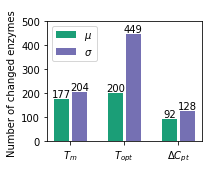

In [24]:
plot_significantly_changed_num(dfpvals)

Topt_vp 449 764
Tm_vp 204 764
dCpt_vp 128 764


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


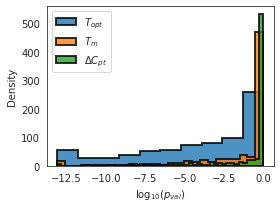

In [12]:
sns.set_style('white')
plt.figure(figsize=(4,3))
cols   = ['Topt_vp','Tm_vp','dCpt_vp']
labels = ['$T_{opt}$', '$T_m$', '$\Delta$$C_{pt}$']
for i,col in enumerate(cols):
    x = dfpvals[col].values
    x[x==0] = np.min(x[x!=0])
    x = np.log10(x)
    print(col,len(x[x<-2]),len(x))
    hist_kws = {"histtype": "stepfilled", "linewidth": 2,"alpha": 0.8, 'edgecolor':'k'}
    sns.distplot(x,label=labels[i],kde=False,hist_kws=hist_kws)
    #plt.hist(x,50,label=col,alpha=0.5)
plt.xlabel('log$_{10}$($p_{val}$)')
plt.ylabel('Density')
#plt.xlim([-20,0])
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../figures/reduced_variance_of_all_enzymes.pdf')
plt.show()

Topt_mp 200
Tm_mp 177
dCpt_mp 92


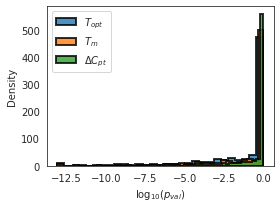

In [15]:
sns.set_style('white')
plt.figure(figsize=(4,3))
cols   = ['Topt_mp','Tm_mp','dCpt_mp']
labels = ['$T_{opt}$', '$T_m$', '$\Delta$$C_{pt}$']
for i,col in enumerate(cols):
    x = dfpvals[col].values
    x[x==0] = np.min(x[x!=0])
    x = np.log10(x)
    print(col,len(x[x<-2]))
    hist_kws = {"histtype": "stepfilled", "linewidth": 2,"alpha": 0.8, 'edgecolor':'k'}
    sns.distplot(x,label=labels[i],kde=False,hist_kws=hist_kws)
    #plt.hist(x,50,label=col,alpha=0.5)
plt.xlabel('log$_{10}$($p_{val}$)')
plt.ylabel('Density')
#plt.xlim([-20,0])
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('../figures/reduced_variance_of_all_enzymes.pdf')
plt.show()

ttest: 3.2298954043357337e-15
ftest: 0.7979379021178117

ttest: 0.2641318338825822
ftest: 0.151317118757904

ttest: 6.679384506552166e-14
ftest: 0.1538252487016334



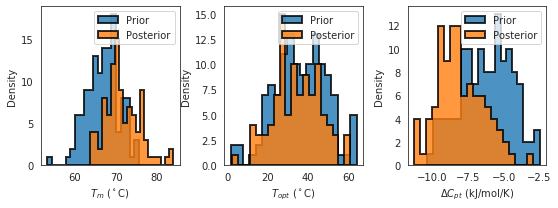

P22217


In [22]:
for prot in dfpvals.index:
    if dfpvals.loc[prot,'dCpt_vp']>1e-1 and dfpvals.loc[prot,'Tm_vp']>1e-1 and dfpvals.loc[prot,'Topt_vp']>1e-1: 
        plot_param_dist_prior_posterior(model,prot)
        print(prot)
        break

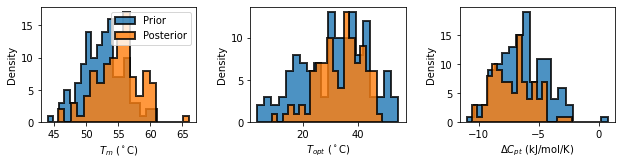

In [24]:
plot_param_dist_prior_posterior(model,'P07244',True)

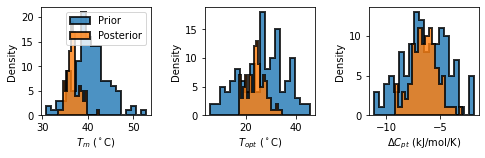

In [28]:
plot_param_dist_prior_posterior(model,'P32476',True,figsize=(6.85,2.3))

ttest: 2.2766391314820728e-05
ftest: 6.706345976992267e-05

ttest: 5.7005029076145634e-06
ftest: 2.826445921755294e-08

ttest: 0.0483454415747963
ftest: 0.0015150423080249054



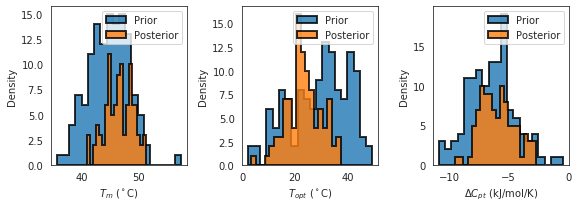

In [25]:
plot_param_dist_prior_posterior(model,'Q12154',True)

ttest: 0.5992975245772949
ftest: 0.46245170009847336

ttest: 0.03256271355078963
ftest: 0.003155455377164551

ttest: 0.005671367638645991
ftest: 0.005297590911311989



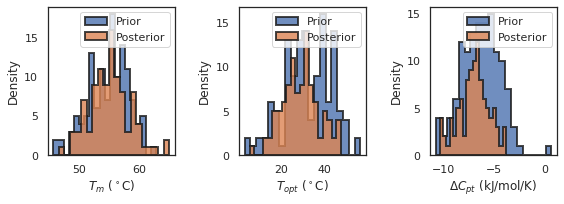

In [135]:
plot_param_dist_prior_posterior(model,'P32377')

ttest: 0.5992975245772949
ftest: 0.46245170009847336

ttest: 0.03256271355078963
ftest: 0.003155455377164551

ttest: 0.005671367638645991
ftest: 0.005297590911311989



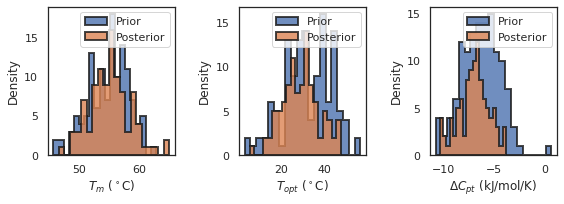

In [136]:
plot_param_dist_prior_posterior(model,'P32377')

ttest: 0.0018603630791595243
ftest: 0.6794548003332056

ttest: 2.8256639085657016e-05
ftest: 2.917099186650063e-07

ttest: 0.0016560226519190093
ftest: 9.037215420448774e-14



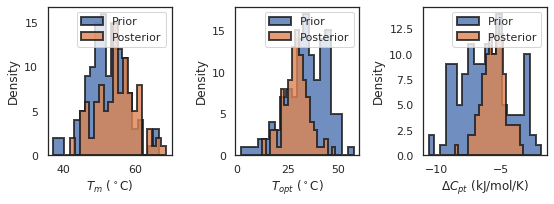

In [137]:
plot_param_dist_prior_posterior(model,'P10963')

In [27]:
def plot_distance_dist(model):
    x1 = -np.array(model.distances_t0)
    x2 = -np.array(model.distances)
    #print(x1)
    x1[x1<-10]=-10
    #print(x2)
    xlabels = ['$T_m$ ($^\circ$C)','$T_{opt}$ ($^\circ$C)','$\Delta$$C_{pt}$ (kJ/mol/K)']
    plt.figure(figsize=(4,3))
    #sns.kdeplot(x1, shade=True,label='Prior')
    sns.kdeplot(x2, shade=True,label='Posterior')
    
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

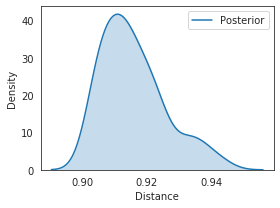

In [28]:
plot_distance_dist(model)

169
1.9638817012051728 -0.9025867096292437


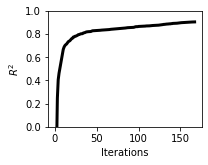

0.9025867096292437


In [6]:
plt.figure(figsize=(3,2.4))
plt.plot(np.arange(len(model.epsilons)-1),-np.array(model.epsilons[1:]),'k-',linewidth=3)
plt.ylim([0,1])
print(len(model.epsilons))
print(model.epsilons[1],model.epsilons[-1])
plt.xlabel('Iterations')
plt.ylabel('$R^2$')
plt.tight_layout()
plt.savefig('../figures/iterations.pdf')
plt.show()
print(-model.epsilons[-1])

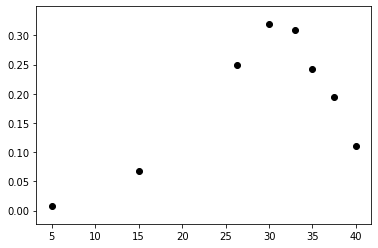

In [41]:
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
plt.scatter(sel_temp,dfan_batch.loc[sel_temp,'r_an'],color='k')

In [7]:
params = pd.read_csv('../data/model_enzyme_params.csv',index_col=0)

### Use param mean of prior and posterior to simulate data

In [ ]:
results = pickle.load(open('../results/param_mean_prior_posterior.pkl','rb'))
dfae_batch,dfan_batch = GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [ ]:
plt.figure(figsize=(4,3))
sns.set_style('white')
plt.scatter(dfae_batch.index,dfae_batch['r_ae'],label='experimental')
plt.plot(dfae_batch.index,results['prior']['rae'],label='prior')
plt.plot(dfae_batch.index,results['posterior']['rae'],label='posterior')
plt.legend()
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.title('Aerobic')
plt.show()

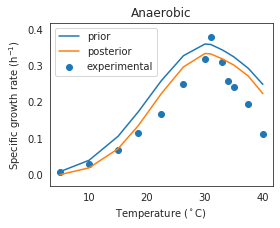

In [124]:
plt.figure(figsize=(4,3))
sns.set_style('white')
plt.scatter(dfan_batch.index,dfan_batch['r_an'],label='experimental')
plt.plot(dfan_batch.index,results['prior']['ran'],label='prior')
plt.plot(dfan_batch.index,results['posterior']['ran'],label='posterior')
plt.legend()
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.title('Anaerobic')
plt.show()

In [131]:
def plot_param_mean_simulation(results):
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    yt0 = results['prior']['chemostat']
    yt = results['posterior']['chemostat']
    for i in range(3):
        plt.figure(figsize=(4,3.2))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0,color='#1f78b4',label='prior')
        #plt.fill_between(dfchemo.index,y0-1.96*yerr0,y0+1.96*yerr0,alpha=0.8,color='#1f78b4')
        
        y = yt[i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y,color='#fc8d59',label='posterior')
        #plt.fill_between(dfchemo.index,y-1.96*yerr,y+1.96*yerr,alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        plt.legend(loc='upper left',fontsize=8)
        plt.title(titles[i])
        plt.tight_layout()
        #if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

4.260765416666666


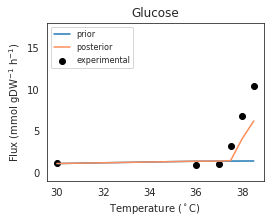

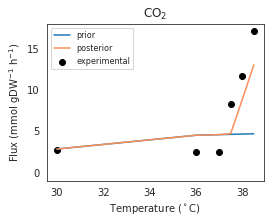

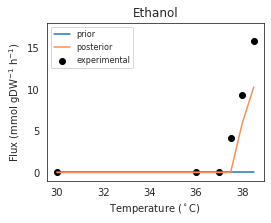

In [132]:
plot_param_mean_simulation(results)

In [8]:
def load_param_mean_std(population):
    # return a datafram with Tm, Topt, dCpt as columns
    params_lst = {idd:[p[idd] for p in population] for idd in population[0].keys()}
    df = pd.DataFrame()
    
    for idd,lst in params_lst.items():
        [prot,param] = idd.split('_')
        if param in ['Tm','Topt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst) - 273.15 # C
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)
        if param in ['dCpt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst)/1000 # kJ/mol/K
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)/1000
    return df

In [9]:
abcsmc = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles.pkl','rb'))
dfprior = load_param_mean_std(abcsmc.population_t0)
dfpost = load_param_mean_std(abcsmc.population)

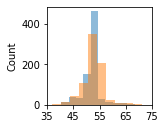

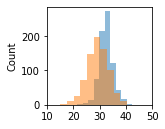

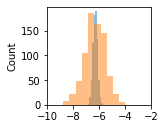

In [21]:
proteins = dfprior.index
labels = ['$T_m$ ($^\circ$C)','$T_{opt}$ ($^\circ$C)','$\Delta$$C_{pt}$ (kJ/mol/K)']
mean_ticks = [np.arange(35,85,10),np.arange(10,60,10),np.arange(-10,0,2)]
for i,item in enumerate(['Tm','Topt','dCpt']):
    plt.figure(figsize=(2.4,1.9))
    plt.hist(dfprior['{0}_mean'.format(item)],label='prior',alpha=0.5)
    plt.hist(dfpost.loc[proteins,'{0}_mean'.format(item)],label='posterior',alpha=0.5)
    #plt.legend()
    #plt.xlabel(labels[i])
    plt.xticks(mean_ticks[i])
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('../figures/{0}_mean_hist.pdf'.format(item))
    plt.show()

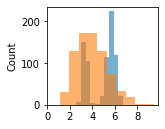

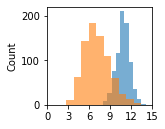

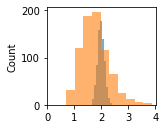

In [22]:
labels = ['$T_m$ ($^\circ$C)','$T_{opt}$ ($^\circ$C)','$\Delta$$C_{pt}$ (kJ/mol/K)']
var_ticks = [np.arange(0,10,2),np.arange(0,18,3),np.arange(0,5,1)]
for i,item in enumerate(['Tm','Topt','dCpt']):
    plt.figure(figsize=(2.4,1.9))
    plt.hist(dfprior['{0}_std'.format(item)],label='prior',alpha=0.6)
    plt.hist(dfpost.loc[proteins,'{0}_std'.format(item)],label='posterior',alpha=0.6)
    #plt.legend()
    #plt.xlabel(labels[i])
    plt.xticks(var_ticks[i])
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('../figures/{0}_std_hist.pdf'.format(item))
    plt.show()

31.76389728096677
51.15526553199998


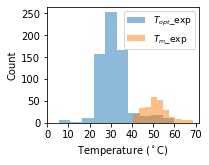

In [27]:
topt_file = '../data/Topt_Record_Brenda.tsv'
df_topts_exp = pd.read_csv(topt_file,index_col=0,sep='\t')
df_topts_exp.shape

tm_file = '../data/model_enzyme_params.csv'
dftm = pd.read_csv(tm_file,index_col=0)
sel_ind = dftm.index[dftm['Tm_std'].values<5]
dftm = dftm.loc[sel_ind,:]

#tkcat_file = '../results/half_kcat_T_posterior.csv'
#dfkcat_T = pd.read_csv(tkcat_file,index_col=0)


plt.figure(figsize=(3.,2.4))
plt.hist(df_topts_exp.loc['saccharomyces_cerevisiae','temperature'],label='$T_{opt}$_exp',alpha=0.5)
plt.hist(dftm['Tm']-273.15,label='$T_m$_exp',alpha=0.5)
#plt.hist(dfkcat_T['half_kcat_T'].values, label='$T_{1/2 k_{cat}}$',alpha=0.5)

print(np.mean(df_topts_exp.loc['saccharomyces_cerevisiae','temperature']))
print(np.mean(dftm['Tm']-273.15))
#print(np.mean(dfkcat_T['half_kcat_T']))

plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Count')
#plt.hist(dfpost['Topt_mean'],label='$T_{opt}$_pos',alpha=0.5)
#plt.hist(dfpost['Tm_mean'],label='$T_m$_pos',alpha=0.5)
plt.xticks(np.arange(0,80,10))
plt.legend(ncol=1,fontsize=9,loc='upper right')
plt.yticks(np.arange(0,300,50))
plt.tight_layout()
plt.savefig('../figures/Topt_vs_Tm_exp.pdf')

In [14]:
topt_c = {}
for t in df_topts_exp.loc['saccharomyces_cerevisiae','temperature']: topt_c[t] = topt_c.get(t,0) + 1
lst = [[v,t] for t,v in topt_c.items()]
lst.sort()
print(lst)

[[1, 5.5], [1, 5.9], [1, 7.0], [1, 7.4], [1, 7.9], [1, 15.0], [1, 28.0], [1, 29.0], [1, 44.0], [1, 46.0], [1, 47.0], [1, 51.0], [1, 57.0], [2, 7.5], [2, 31.0], [2, 38.0], [2, 42.0], [3, 26.0], [3, 33.0], [3, 43.0], [4, 32.0], [4, 36.0], [5, 24.0], [5, 55.0], [6, 60.0], [7, 23.0], [7, 27.0], [10, 20.0], [13, 45.0], [15, 35.0], [17, 50.0], [18, 40.0], [24, 22.0], [111, 25.0], [142, 37.0], [244, 30.0]]


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, 

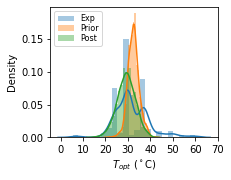

In [18]:
plt.figure(figsize=(3,2.4))
sns.distplot(df_topts_exp.loc['saccharomyces_cerevisiae','temperature'],label='Exp')
plt.ylabel('Density')
sns.distplot(dfprior['Topt_mean'],label='Prior')
sns.distplot(dfpost['Topt_mean'],label='Post')
#plt.hist(dfpost['Tm_mean'],label='$T_m$_pos',alpha=0.5)
plt.legend(loc='upper left',fontsize=8,labelspacing=0.1)
plt.xlabel('$T_{opt}$ ($^\circ$C)')
plt.xticks(np.arange(0,80,10))
plt.tight_layout()

plt.savefig('../figures/Topt_exp_vs_pos_vs_prior.pdf')

In [34]:
?plt.legend

/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

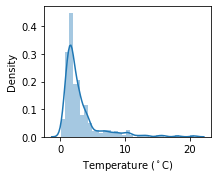

In [24]:
plt.figure(figsize=(3,2.4))
sns.distplot(dftm['T90']-dftm['Tm'])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Density')

In [15]:
?sns.jointplot

In [7]:
proteins = dfprior.index
sns.set_style('ticks')
lims = {'Tm':(35,75), 'Topt': (10,50), 'dCpt':(-10,-3)}
ticks = {'Tm':np.arange(35,85,10), 'Topt': np.arange(10,55,10), 'dCpt':np.arange(-10,-0,2)}
cs = {'Topt':'#1b9e77', 'Tm':'#d95f02', 'dCpt':'#7570b3'}
xlabels = {'Tm':'$T_m$ ($^\circ$C)', 'Topt': '$T_{opt}$ ($^\circ$C)','dCpt':'$\Delta$$C_p$ (kJ/mol/k)'}
for item in ['Tm','Topt','dCpt']:
    #plt.errorbar(dfprior['{0}_mean'.format(item)],dfpost.loc[proteins,'{0}_mean'.format(item)],fmt='o')
                #xerr=dfprior['{0}_std'.format(item)],yerr=dfpost.loc[proteins,'{0}_std'.format(item)],fmt='o')
    if item in  ['Tm','Topt']:
        p1 = 'Prior ($^\circ$C)'
        p2 = 'Posterior ($^\circ$C)'
    else: 
        p1 = 'Prior (kJ/mol/K)'
        p2 = 'Posterior (kJ/mol/K)'
    df = pd.DataFrame(data={p1:list(dfprior.loc[proteins,'{0}_mean'.format(item)]),
                            p2:list(dfpost.loc[proteins,'{0}_mean'.format(item)])})
    
    fig = sns.jointplot(x=p1,
                        y=p2,
                        data=df, 
                        kind='scatter',
                        height=2.5,
                        color=cs[item],
                        xlim=lims[item],
                        ylim=lims[item],
                        alpha=0.4,
                        space=0.,
                        ratio=3,
                        marginal_kws={
                        'hist': True, 'rug': False, 'kde': False,
                        'hist_kws':{'alpha':0.9,"histtype": "stepfilled", "linewidth": 2, 'edgecolor':'k'}
                    })
    ##d95f02
    
    
    fig.ax_joint.set_xticks(ticks[item])
    fig.ax_joint.set_yticks(ticks[item])
    fig.ax_joint.plot(lims[item],lims[item],'k')
    
    #fig.ax_marg_x.set_alpha(0.9)
    #fig.ax_marg_x.axes.set_fc('k')
    '''
    fig.ax_joint.plot(lim,lim,'k')
    fig.ax_joint.set_xlim(lim)
    fig.ax_joint.set_ylim(lim)
    
    
    '''
    #plt.xlabel('Prior')
    #plt.ylabel('Posterior')
    #plt.title(item)
    plt.tight_layout()
    plt.savefig('../figures/{0}_mean.pdf'.format(item))
    plt.show()
    

NameError: name 'dfprior' is not defined

4.879794313012096 3.9925333878753397


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, 

<Figure size 288x216 with 0 Axes>

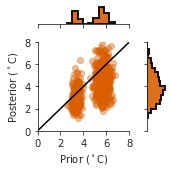

10.877961998484366 7.126355048560392


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, 

<Figure size 288x216 with 0 Axes>

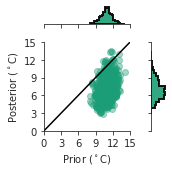

1.9890617889953073 1.7782335514858645


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, 

<Figure size 288x216 with 0 Axes>

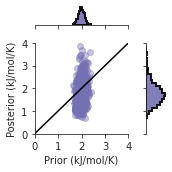

In [ ]:
proteins = dfprior.index
sns.set_style('ticks')
lims = {'Tm':(0,8), 'Topt': (0,15), 'dCpt':(0,4)}
ticks = {'Tm':np.arange(0,10,2), 'Topt': np.arange(0,18,3), 'dCpt':np.arange(0,5,1)}
cs = {'Topt':'#1b9e77', 'Tm':'#d95f02', 'dCpt':'#7570b3'}
for item in ['Tm','Topt','dCpt']:
    plt.figure(figsize=(4,3))
    #plt.errorbar(dfprior['{0}_mean'.format(item)],dfpost.loc[proteins,'{0}_mean'.format(item)],fmt='o')
                #xerr=dfprior['{0}_std'.format(item)],yerr=dfpost.loc[proteins,'{0}_std'.format(item)],fmt='o')
    if item in  ['Tm','Topt']:
        p1 = 'Prior ($^\circ$C)'
        p2 = 'Posterior ($^\circ$C)'
    else: 
        p1 = 'Prior (kJ/mol/K)'
        p2 = 'Posterior (kJ/mol/K)'
    df = pd.DataFrame(data={p1:list(dfprior.loc[proteins,'{0}_std'.format(item)]),
                            p2:list(dfpost.loc[proteins,'{0}_std'.format(item)])})
    print(np.mean(dfprior.loc[proteins,'{0}_std'.format(item)]),
          np.mean(dfpost.loc[proteins,'{0}_std'.format(item)]))
    
    fig = sns.jointplot(x=p1,
                        y=p2,
                        data=df, 
                        kind='scatter',
                        height=2.5,
                        color=cs[item],
                        xlim=lims[item],
                        ylim=lims[item],
                        alpha=0.4,
                        space=0.,
                        ratio=3,
                        marginal_kws={
                        'hist': True, 'rug': False, 'kde': False,
                        'hist_kws':{'alpha':0.9,"histtype": "stepfilled", "linewidth": 2, 'edgecolor':'k'}
                    })
    ##d95f02
    
    
    fig.ax_joint.set_xticks(ticks[item])
    fig.ax_joint.set_yticks(ticks[item])
    fig.ax_joint.plot(lims[item],lims[item],'k')
    
    #fig.ax_marg_x.set_alpha(0.9)
    #fig.ax_marg_x.axes.set_fc('k')
    '''
    fig.ax_joint.plot(lim,lim,'k')
    fig.ax_joint.set_xlim(lim)
    fig.ax_joint.set_ylim(lim)
    
    
    '''
    #plt.xlabel('Prior')
    #plt.ylabel('Posterior')
    #plt.title(item)
    plt.tight_layout()
    plt.savefig('../figures/{0}_std.pdf'.format(item))
    plt.show()

In [135]:
dfpvals.head(n=5)

,Tm_mp,Tm_vp,Topt_mp,Topt_vp,dCpt_mp,dCpt_vp
O13525,9.094461e-02,0.002531,1.240670e-01,1.110223e-16,0.889558,0.099093
P00044,1.889672e-01,1.000000,5.999472e-01,1.110223e-16,0.130899,1.000000
P00045,4.001264e-08,0.988943,7.461871e-02,7.244205e-13,0.580189,0.000010
P00127,3.017258e-01,0.000446,2.098642e-11,4.444016e-02,0.129314,0.000005
P00128,2.421909e-01,0.062636,1.240243e-11,4.634072e-05,0.004226,0.006633


#### Splited factors

In [2]:
def plot_splited_factors():
    sns.set_style('ticks')
    plt.figure(figsize=(3,2.4))
    results = pickle.load(open('../results/splited_factors_poppulation.pkl','rb'))
    #print(results)
    Ts = np.arange(5,46,3)
    keys   = ['ori','NGAM','kcat','unfolding','etc']
    labels = ['ec','ec+NGAM($T$)','ec+$k_{cat}$($T$)','ec+denaturation($T$)','etc']
    cs =     ['#386cb0', '#beaed4','#7fc97f',  '#e78ac3', '#fc8d59']
    
    def _plot_a_type(key,label,c):
        x = list()
        for i in range(100):
            lst = [0 if item is None else item for item in results[i][key]]
            x.append(lst)
        x = np.array(x)
        x[x==None] = 0
        #y_mean = np.mean(x,axis=0)
        #y_err = np.std(x,axis=0)
        y = np.percentile(x,[5,50,95],axis=0)
        plt.plot(Ts,y[1,:],color=c,label=label)
        plt.fill_between(Ts,y[0,:],y[2,:],alpha=0.5,color=c)
        
        return y[1,:]
    
    rs = dict()
    for i,key in enumerate(keys): rs[key]=_plot_a_type(key,labels[i],cs[i])
    #plt.ylim([0,1])
    #plt.legend(loc='lower left')
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Specific growth rate (h$^{-1}$)')
    plt.tight_layout()
    plt.savefig('../figures/splited_factors.pdf',transparent=True)
    plt.show()
    
    plt.figure(figsize=(3,2.4))
    for i,key in enumerate(keys): plt.plot([],[],color=cs[i],label=labels[i])
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/splited_factors_legend.pdf',transparent=True)
    plt.show()
    return rs

In [10]:
from sklearn.metrics import r2_score 

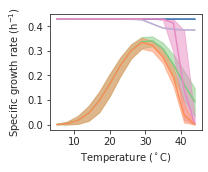

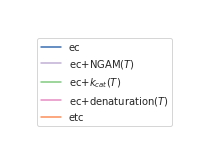

In [3]:
rs = plot_splited_factors()

In [11]:
for k, x in rs.items(): 
    print(k, r2_score(rs['etc'],rs[k]))

ori -5.121968350384904
NGAM -4.650827793422013
kcat 0.8717050376459177
unfolding -3.6089502874524824
etc 1.0


In [14]:
dir(etcpy.etc)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'calculate_kcatT',
 'calculate_thermal_params',
 'change_rxn_coeff',
 'fsolve',
 'getNGAMT',
 'get_dGu',
 'get_dH_dS_dCpu_from_TmLength',
 'get_dH_dS_dCpu_from_TmT90',
 'get_fNT',
 'map_fNT',
 'map_kcatT',
 'np',
 'pd',
 'sample_data_uncertainty',
 'sample_data_uncertainty_with_constraint',
 'set_NGAMT',
 'set_sigma',
 'simulate_chomostat',
 'simulate_growth',
 'time']

#### FCC

In [37]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [38]:
def plot_fcc_of_an_enzyme(name):
    gene_names,gene_ids = load_gene_names()
    prot = gene_ids[name]
    results = pickle.load(open('../results/fcc_population_all_particles.pkl','rb'))
    Ts = list(results[0].columns)
    Ts.sort()
    Ts = Ts[:-1]
    Ts = np.array(Ts)
    X = [[] for _ in Ts]
    for df in results:
        df = df[Ts]
        for i,col in enumerate(Ts):
            x = df.loc[prot,col]
            if x is not None and ~np.isnan(x): X[i].append(x)
    #x_mean = np.array([np.mean(x) for x in X])
    #x_err = np.array([1.96*np.std(x) for x in X])
    pcr = [np.percentile(x,[5,50,95]) for x in X]
    pcr = np.array(pcr)
    plt.plot(Ts-273.15,pcr[:,1])
    plt.fill_between(Ts-273.15,pcr[:,0], pcr[:,2],alpha=0.5,label=name)
    
    

In [39]:
def load_pcrs():
    # load [5,50,95] percentiles for each enzyme
    gene_names = load_gene_names()
    results = pickle.load(open('../results/fcc_population_all_particles.pkl','rb'))
    proteins = results[0].index
    fccs = dict() # {t:[[]*100]}
    for df in results:
        df = df.loc[proteins,:]
        for t in df.columns: 
            if t == 45+273.15: continue # ignore 45C
            lst = fccs.get(t,[])
            lst.append([np.nan if item is None else item for item in df[t]])
            fccs[t] = lst
    
    # calculate percentile
    pcr5, pcr50, pcr95 = {}, {}, {} # {temperature: [lst]}
    for t,data in fccs.items():
        data = np.array(data)
        
        pcr5[t] = np.nanpercentile(data,5,axis=0)
        pcr50[t] = np.nanpercentile(data,50,axis=0)
        pcr95[t] = np.nanpercentile(data,95,axis=0)
    
    df5 = pd.DataFrame(data=pcr5,index=proteins)
    df50 = pd.DataFrame(data=pcr50,index=proteins)
    df95 = pd.DataFrame(data=pcr95,index=proteins)
    
    print(df5.shape,df50.shape,df95.columns,df95.index)
    return df5,df50,df95

In [40]:
def plot_filtered_enzymes(df5,df50,df95,outname=None):
    # plot top 6 in terms of df50 max
    #lst = [(np.max(df50.loc[prot,:]), prot) for prot in df50.index]
    sns.set_style('ticks')
    lst = [(df50.loc[prot,42+273.15], prot) for prot in df50.index]
    lst.sort(reverse=True)
    sel_prots = [item[1] for item in lst[:5]]
    
    gene_names,gene_ids = load_gene_names()
    Ts = list(df50.columns)
    Ts.sort()

    df5,df50,df95 = df5.loc[sel_prots,Ts],df50.loc[sel_prots,Ts],df95.loc[sel_prots,Ts]
    #df5[df5<0]=0
    ticks = {'ERG1':np.arange(0,1,0.25),
             'TDH1':np.arange(0,0.25,0.05),
             'TDH3':np.arange(0,0.08,0.02),
             'TDH2':np.arange(0,0.08,0.02),
             'PDC1':np.arange(0,0.025,0.005),
             'FBA1':np.arange(0,0.08,0.02)}
    Ts = np.array(Ts)
    plt.figure(figsize=(8.5,2.4))
    for i,prot in enumerate(df50.index):
        plt.subplot(1,5,i+1)
        gene_name = gene_names[prot]
    
        plt.plot(Ts-273.15,df50.loc[prot,:],color='k')
        plt.fill_between(Ts-273.15,df5.loc[prot,:], df95.loc[prot,:],alpha=0.5,label=gene_name,color='gray')
        ylim = list(plt.gca().get_ylim())
        ylim[0]=-0.01*(ylim[1]-ylim[0])
        plt.ylim(ylim)
        plt.xlabel('Temperature ($^\circ$C)')
        if i in [0]:
            plt.ylabel('FCC')
            #plt.yticks(ticks[gene_name],fontsize=8)
        else:
            plt.yticks([])
        plt.title(gene_name,fontsize=10)
        plt.xticks(np.arange(5,50,10))
        #plt.yticks(ticks[gene_name],fontsize=8)
        
        #plt.yticks(np.arange(0,1.25,0.25))
        plt.ylim((-0.01,0.3))
        #plt.yscale('log')
    #plt.legend(loc='upper center')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname,transparent=True)
    plt.show()

In [41]:
def remove_small_fccs(df5,df50,df95,thr):
    # remove proteins with a median fcc less than thr at all temperatures
    sel_prots = list()
    for prot in df50.index:
        if np.max(df50.loc[prot,:])<thr: continue
        sel_prots.append(prot)
    
    print(len(sel_prots))
    return df5.loc[sel_prots,:],df50.loc[sel_prots,:],df95.loc[sel_prots,:]

In [42]:
def do_bar_plot_at_given_temperature(df5,df50,df95,T, top_num = 10):
    # T in °C
    # dfx is the x-percentile 
    # top_num, plot the top_num enzymes with highest median value
    gene_names,gene_ids = load_gene_names()
    
    sel_enzymes = list(df50.index[np.argsort(df50[T+273.15].values)])[-top_num:]
    sel_enzymes.reverse()
    print(sel_enzymes)
    
    plt.figure(figsize=(5.5,2.2))
    x = np.arange(top_num)
    plt.bar(x,df50.loc[sel_enzymes,T+273.15],
            yerr=[df50.loc[sel_enzymes,T+273.15]-df5.loc[sel_enzymes,T+273.15],
                  df95.loc[sel_enzymes,T+273.15]-df50.loc[sel_enzymes,T+273.15]],
            capsize=5,
            color='#fc8d59')
    plt.yscale('log')
    plt.xticks(x,[gene_names[uni] for uni in sel_enzymes],rotation=90)
    plt.ylabel('Flux control coefficient')
    plt.ylim(1e-5,1e0+0.3)
    plt.xlim(-0.7,x[-1]+0.7)
    plt.yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
    #plt.tight_layout()
    plt.savefig('../figures/fccs_at_42C.pdf',bbox_inches='tight')
    plt.show()

In [43]:
def load_fccs_at_T(T):
    # load [5,50,95] percentiles for each enzyme
    gene_names = load_gene_names()
    results = pickle.load(open('../results/fcc_population_all_particles.pkl','rb'))
    proteins = results[0].index
    fccs = dict() # {t:[[]*100]}
    for df in results:
        df = df.loc[proteins,:]
        for t in df.columns: 
            if t == 45+273.15: continue # ignore 45C
            lst = fccs.get(t,[])
            lst.append([np.nan if item is None else item for item in df[t]])
            fccs[t] = lst
    
    # calculate percentile
    pcr5, pcr50, pcr95 = {}, {}, {} # {temperature: [lst]}
    for t,data in fccs.items():
        data = np.array(data)
        
        pcr5[t] = np.nanpercentile(data,5,axis=0)
        pcr50[t] = np.nanpercentile(data,50,axis=0)
        pcr95[t] = np.nanpercentile(data,95,axis=0)
    
    
    
    print(df5.shape,df50.shape,df95.columns,df95.index)
    return df5,df50,df95

In [44]:
def load_fccs_population_at_T(T):
    # load fccs of all particle for each enzyme at T
    gene_names = load_gene_names() 
    results = pickle.load(open('../results/fcc_population_all_particles.pkl','rb'))
    proteins = results[0].index
    fccs = pd.DataFrame() # {prot:[fcc*100]}
    for i,df in enumerate(results):
        df = df.loc[proteins,:]
        fccs[i] = [np.nan if item is None else item for item in df[T+273.15].values]
    fccs.index = proteins
    return fccs

In [45]:
def do_box_plot_at_given_temperature(T, top_num = 10):
    # T in °C
    # dfx is the x-percentile 
    # top_num, plot the top_num enzymes with highest median value
    gene_names,gene_ids = load_gene_names()
    fccs = load_fccs_population_at_T(T)
    
    lst50 = [(np.nanmedian(fccs.loc[ind,:].values),ind) for ind in fccs.index]
    lst50.sort()
    
    sel_enzymes = [item[1] for item in lst50[-top_num:]]
    sel_enzymes.reverse()
    print(sel_enzymes)
    
    plt.figure(figsize=(5.5,2.2))
    x = np.arange(top_num)+1
    data = [ [v for v in fccs.loc[ind,:].values if ~np.isnan(v)] for ind in sel_enzymes]
    bp = plt.boxplot(data,showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='k')
    for i,pos in enumerate(x):
        plt.scatter(np.array([pos]*len(data[i]))+np.random.normal(0,0.05,len(data[i])),
                    data[i],
                    color='#fc8d59',
                    s=2)
    '''
    plt.bar(x,df50.loc[sel_enzymes,T+273.15],
            yerr=[df50.loc[sel_enzymes,T+273.15]-df5.loc[sel_enzymes,T+273.15],
                  df95.loc[sel_enzymes,T+273.15]-df50.loc[sel_enzymes,T+273.15]],
            capsize=5,
            color='#fc8d59')
    '''
    plt.yscale('log')
    plt.xticks(x,[gene_names[uni] for uni in sel_enzymes],rotation=90)
    plt.ylabel('Flux control coefficient')
    plt.ylim(1e-5,1e0+0.3)
    plt.xlim(.3,x[-1]+0.7)
    plt.yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
    #plt.tight_layout()
    plt.savefig('../figures/fccs_at_{0}C_boxplot.pdf'.format(T),bbox_inches='tight')
    plt.show()

In [57]:
def do_box_plot_at_given_temperatures(Ts, top_num = 10):
    # T in °C, Ts: [40,42]
    # dfx is the x-percentile 
    # top_num, plot the top_num enzymes with highest median value
    gene_names,gene_ids = load_gene_names()
    fccs1 = load_fccs_population_at_T(Ts[0])
    fccs2 = load_fccs_population_at_T(Ts[1])
    
    lst50 = [(np.nanmedian(fccs2.loc[ind,:].values),ind) for ind in fccs2.index]
    lst50.sort()
    
    sel_enzymes = [item[1] for item in lst50[-top_num:]]
    sel_enzymes.reverse()
    print(sel_enzymes)
    
    plt.figure(figsize=(5.5,2.2))
    x = np.arange(top_num)*3
    data1 = [ [v for v in fccs1.loc[ind,:].values if ~np.isnan(v)] for ind in sel_enzymes]
    data2 = [ [v for v in fccs2.loc[ind,:].values if ~np.isnan(v)] for ind in sel_enzymes]
    
    
    def _do_one_T_plot(data,x,color,label):
        bp = plt.boxplot(data,showfliers=False,positions=x)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='k')
        for i,pos in enumerate(x):
            if i>0: label=None
            plt.scatter(np.array([pos]*len(data[i]))+np.random.normal(0,0.05,len(data[i])),
                        data[i],
                        color=color,
                        s=2,
                        label=label)
    _do_one_T_plot(data1,x,color='#fdae6b',label='40 $^\circ$C')
    _do_one_T_plot(data2,x+1,color='#a50f15',label='42 $^\circ$C')
    
    plt.yscale('log')
    plt.xticks(x+0.5,[gene_names[uni] for uni in sel_enzymes],rotation=90)
    plt.ylabel('Flux control coefficient')
    plt.ylim(1e-5,1e0+0.3)
    plt.xlim(-1,x[-1]+2)
    plt.yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
    plt.legend(fontsize=8)
    #plt.tight_layout()
    plt.savefig('../figures/fccs_at_40_42C_boxplot.pdf',bbox_inches='tight')
    plt.show()

In [47]:
fccs = load_fccs_population_at_T(40)
fccs.to_csv('../results/fccs_at_40_100_models_figure5a.csv')

['P32476', 'P00360', 'P00359', 'P00358', 'P06169', 'P14540', 'P26263', 'P16467', 'P15019', 'P00924', 'P00925', 'P00549', 'P52489', 'P16862', 'P17709', 'P04807', 'P04806', 'P00560', 'P00950', 'P16861']


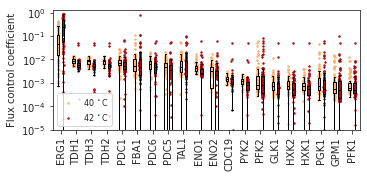

In [58]:
do_box_plot_at_given_temperatures([40,42], top_num = 20)

['P32476', 'P00360', 'P00359', 'P00358', 'P06169', 'P14540', 'P26263', 'P16467', 'P15019', 'P00924', 'P00925', 'P00549', 'P52489', 'P16862', 'P17709', 'P04807', 'P04806', 'P00560', 'P00950', 'P16861']


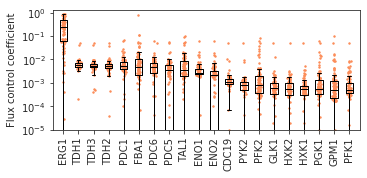

In [104]:
do_box_plot_at_given_temperature(42, top_num = 20)

['P32476', 'P00360', 'P00359', 'P00358', 'P06169', 'P26263', 'P14540', 'P16467', 'P15019', 'P00924', 'P00925', 'P12684', 'P12683', 'Q06817', 'P00549', 'P38088', 'P52489', 'Q12122', 'P05694', 'P48570']


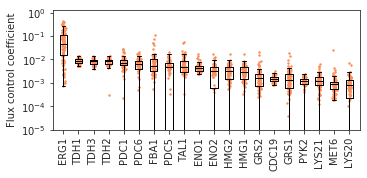

In [105]:
do_box_plot_at_given_temperature(40, top_num = 20)

In [105]:
df5,df50,df95 = load_pcrs()
#df5,df50,df95 = remove_small_fccs(df5,df50,df95,0.01)

(764, 10) (764, 10) Float64Index([278.15, 283.15, 288.15, 293.15, 298.15, 303.15, 308.15, 310.15,
              313.15, 315.15],
             dtype='float64') Index(['P04076', 'P36010', 'P47125', 'P07284', 'Q01217', 'P47039', 'P00899',
       'P38342', 'P35842', 'P47147',
       ...
       'Q07938', 'P17898', 'Q10740', 'P09457', 'P04806', 'Q06346', 'P38067',
       'P47176', 'P0CX78', 'Q01574'],
      dtype='object', length=764)


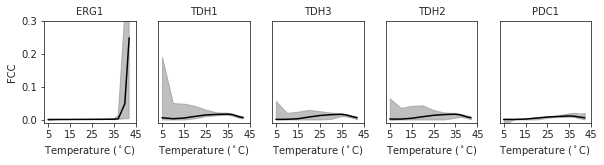

In [69]:
plot_filtered_enzymes(df5,df50,df95,'../figures/fcc_top6.pdf')

def plot_fcc_of_top_enzymes(dfmean,dfci,outname=None):
    gene_names,gene_ids = load_gene_names()
    Ts = list(dfmean.columns)
    Ts.sort()
    dfmean,dfci = dfmean[Ts],dfci[Ts]
    
    Ts = np.array(Ts)
    plt.figure(figsize=(8,5))
    for i,prot in enumerate(dfmean.index):
        plt.subplot(2,3,i+1)
        gene_name = gene_names[prot]
        x_mean = dfmean.loc[prot,Ts]
        x_err = dfci.loc[prot,Ts]
        plt.plot(Ts-273.15,x_mean,color='r')
        plt.fill_between(Ts-273.15,x_mean+x_err, x_mean-x_err,alpha=0.5,label=gene_name,color='r')
        ylim = list(plt.gca().get_ylim())
        ylim[0]=0
        plt.ylim(ylim)
        if i > 2: plt.xlabel('Temperature ($^\circ$C)')
        if i in [0,3]:plt.ylabel('FCC')
        plt.title(gene_name)
        plt.xticks(np.arange(5,50,5))
        plt.yticks(np.arange(0,1.25,0.25))
        plt.ylim((0,1))
    #plt.legend(loc='upper center')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

def calculate_fcc_mean_std():
    gene_names = load_gene_names()
    results = pickle.load(open('../results/fcc_population.pkl','rb'))
    proteins = results[0].index
    fccs = dict() # {t:[[]*100]}
    for df in results:
        df = df.loc[proteins,:]
        for t in df.columns: 
            lst = fccs.get(t,[])
            lst.append([np.nan if item is None else item for item in df[t]])
            fccs[t] = lst
    
    # calculate average, std*1.96
    fccs_mean, fccs_std = {}, {}
    for t,data in fccs.items():
        data = np.array(data)
        fccs_mean[t] = np.nanmean(data,axis=0)
        fccs_std[t] = 1.96 * np.nanstd(data,axis=0)

    dfmean = pd.DataFrame(data=fccs_mean,index=proteins)
    dfci = pd.DataFrame(data=fccs_std,index=proteins)
    print(dfmean.shape,dfci.shape,dfmean.columns,dfmean.index)
    return dfmean,dfci

(764, 10) (764, 10) Float64Index([278.15, 283.15, 288.15, 293.15, 298.15, 303.15, 308.15, 310.15,
              313.15, 315.15],
             dtype='float64') Index(['P0CZ17', 'P32347', 'P11491', 'P38631', 'P22768', 'P15179', 'P27697',
       'Q12265', 'P38689', 'Q00055',
       ...
       'P48525', 'P03965', 'Q12109', 'P21182', 'P18900', 'P52910', 'P35202',
       'P33775', 'P54114', 'P00127'],
      dtype='object', length=764)


In [35]:
!pwd

/c3se/NOBACKUP/users/gangl/GitHub/BayesianGEM/code


In [147]:
df50

,278.15,283.15,288.15,293.15,298.15,303.15,308.15,310.15,313.15,315.15
P12684,0.000163,0.000839,0.002548,0.005497,0.008648,0.010043,0.008843,0.007515,0.002904,0.000383
P32476,0.000008,0.000048,0.000131,0.000270,0.000431,0.000549,0.000746,0.001471,0.026485,0.059731
P00358,0.021005,0.024721,0.025268,0.029471,0.023215,0.017955,0.016617,0.014882,0.008845,0.005255
P12683,0.000131,0.000604,0.002151,0.005071,0.008446,0.010154,0.009245,0.007910,0.003676,0.000593
P00360,0.009988,0.023056,0.025566,0.029312,0.024327,0.018247,0.016805,0.014886,0.008870,0.005264
P00359,0.004963,0.008010,0.012069,0.019567,0.019211,0.016397,0.016034,0.014332,0.008403,0.005196
P26263,0.000352,0.000539,0.001670,0.004176,0.007291,0.009059,0.010262,0.009415,0.006077,0.004179


In [105]:
plot_fcc_of_top_enzymes(dfmean,dfci,outname='../figures/fcc_ones_mean_higher_than_0.1.pdf')

NameError: name 'dfmean' is not defined

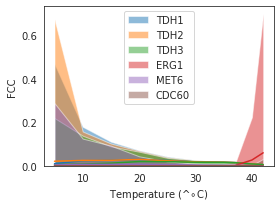

In [106]:
plt.figure(figsize=(4,3))
for name in ['TDH1','TDH2','TDH3','ERG1','MET6','CDC60']:plot_fcc_of_an_enzyme(name)

ylim = list(plt.gca().get_ylim())
ylim[0]=0
plt.ylim(ylim)
plt.xlabel('Temperature (^$\circ$C)')
plt.ylabel('FCC')
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('../figures/fcc_some_enzymes.pdf')
plt.show()

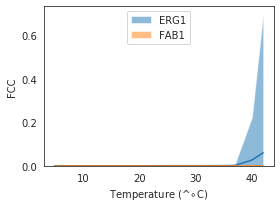

In [107]:
plt.figure(figsize=(4,3))
for name in ['ERG1','FAB1']:plot_fcc_of_an_enzyme(name)

ylim = list(plt.gca().get_ylim())
ylim[0]=0
plt.ylim(ylim)
plt.xlabel('Temperature (^$\circ$C)')
plt.ylabel('FCC')
plt.legend(loc='upper center')
plt.tight_layout()
#plt.savefig('../figures/fcc_some_enzymes.pdf')
plt.show()

#### Rescue ERG1

In [42]:
import random

In [33]:
def rescue_ERG1():
    sns.set_style('ticks')
    results = pickle.load(open('../results/rescue_ERG1_all_particles.pkl','rb'))
    
    
    Ts = np.array([30, 35, 37, 38,39,40,41,42,45])
    
    rs0 = list()
    rs1 = list()
    
    for item in results:
        rs0.append([np.nan if r is None else r for r in item[0]])
        rs1.append([np.nan if r is None else r for r in item[1]])
        
    #plt.figure(figsize=(4,3))
    fig = plt.figure(figsize=(3., 2.4)) 
    #gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    #ax0 = plt.subplot(gs[0])
    #ax1 = plt.subplot(gs[1])
    cs = ['#fc8d62','#66c2a5']
    
    def _plot(data,label,c=None):
        data = np.array(data)
        
        
        ymean = np.nanmean(data,axis=0)
        yerr = np.nanstd(data,axis=0) * 1.96
        ps = np.nanpercentile(data,[5,50,95],axis=0)
        print(ps.shape)
        
        plt.plot(Ts,ps[1,:])
        plt.fill_between(Ts,ps[0,:],ps[2,:],alpha=0.2,label=label)
        
        
        
    
    _plot(rs0,'WT')
    _plot(rs1,'T-ind ERG1')
    
    rs0 = np.array(rs0)
    rs1 = np.array(rs1)
    
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Specific growth rate (h$^{-1}$)')
    
    ylim = list(plt.gca().get_ylim())
    ylim[0] = -0.01
    plt.ylim(ylim)
    plt.legend(fontsize=8,loc='lower left')
    
    
    
    plt.tight_layout()
    plt.savefig('../figures/rescue_ERG1.pdf')
    plt.show()
    
    
    print(rs0.shape,rs1.shape)
    def _plot_T_ind(Tind):
    #Tind = -4
        print(np.percentile(rs0[:,Tind],[5,50,95]))
        print(np.percentile(rs1[:,Tind],[5,50,95]))
        plt.figure(figsize=(1.5,2.4))
        wt  = [item for item in rs0[:,Tind] if ~np.isnan(item)]
        mut = [item for item in rs1[:,Tind] if ~np.isnan(item)]
        data = [wt,mut]


        bp = plt.boxplot([wt,mut],showfliers=False,widths=0.6)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='k')

        for i in range(2):
            plt.scatter(np.array([i+1]*len(data[i]))+np.random.normal(0,0.1,len(data[i])),
                        data[i],
                        color='gray',
                        s=2)

        plt.xticks([1,2],['WT','Temp \ninsensitive\nERG1'])
        #plt.xticks([1,2],['WT','T-ind ERG1'])
        #plt.xticks([1,2],['ScERG1','KmERG1'])
        plt.ylabel('Specific growth rate (h$^{-1}$)')
        plt.ylim(-0.01,0.25)
        #plt.tight_layout()
        plt.savefig('../figures/rescue_ERG1_box_plot_{0}C.pdf'.format(Ts[Tind]),bbox_inches='tight')
        plt.show()
        
        #return 
    
    _plot_T_ind(-4)
    _plot_T_ind(-2)
    

In [67]:
def rescue_ERG1_two():
    sns.set_style('ticks')
    results = pickle.load(open('../results/rescue_ERG1_all_particles.pkl','rb'))
    
    
    Ts = np.array([30, 35, 37, 38,39,40,41,42,45])
    
    rs0 = list()
    rs1 = list()
    
    for item in results:
        rs0.append([np.nan if r is None else r for r in item[0]])
        rs1.append([np.nan if r is None else r for r in item[1]])
        
    #plt.figure(figsize=(4,3))
    fig = plt.figure(figsize=(3., 2.4)) 
    #gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    #ax0 = plt.subplot(gs[0])
    #ax1 = plt.subplot(gs[1])
    cs = ['#fc8d62','#66c2a5']
    
    rs0 = np.array(rs0)
    rs1 = np.array(rs1)
    
    
    print(rs0.shape,rs1.shape)
    def _plot_T_ind(Tind1,Tind2):
    #Tind = -4

        plt.figure(figsize=(3,2.4))
        wt1  = [item for item in rs0[:,Tind1] if ~np.isnan(item)]
        mut1 = [item for item in rs1[:,Tind1] if ~np.isnan(item)]
        
        wt2  = [item for item in rs0[:,Tind2] if ~np.isnan(item)]
        mut2 = [item for item in rs1[:,Tind2] if ~np.isnan(item)]
        
        
        data = [wt1,mut1,wt2,mut2]


        bp = plt.boxplot(data,showfliers=False,widths=0.6)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='k')

        for i in range(len(data)):
            if i<2: c =  '#fdae6b'
            else: c = '#a50f15'
            plt.scatter(np.array([i+1]*len(data[i]))+np.random.normal(0,0.1,len(data[i])),
                        data[i],
                        color=c,
                        s=2)

        plt.xticks([1,2,3,4],['WT','Temp \ninsensitive\nERG1']*2)
        #plt.xticks([1,2],['WT','T-ind ERG1'])
        #plt.xticks([1,2],['ScERG1','KmERG1'])
        plt.ylabel('Specific growth rate (h$^{-1}$)')
        plt.ylim(-0.01,0.25)
        #plt.tight_layout()
        plt.savefig('../figures/rescue_ERG1_box_plot_{0}C_combined.pdf'.format('combined'),bbox_inches='tight')
        plt.show()
        
        #return 
    
    _plot_T_ind(-4,-2)
    #_plot_T_ind(-2)
    

(3, 9)
(3, 9)


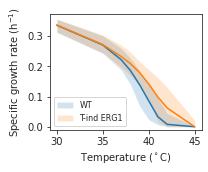

(100, 9) (100, 9)
[0.02323173 0.08552238 0.14147729]
[0.08356859 0.14142068 0.18912338]


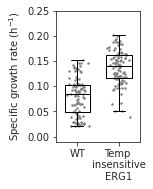

[1.78620409e-09 8.01328983e-03 4.44180777e-02]
[0.         0.06220477 0.13092696]


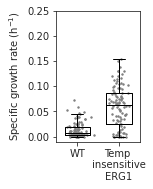

In [34]:
rescue_ERG1()

(100, 9) (100, 9)


<Figure size 216x172.8 with 0 Axes>

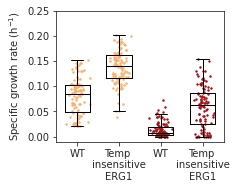

In [68]:
rescue_ERG1_two()

Object `plt.gca().set_xticks` not found.


#### Gradually remove temperature constraints on enzymes based on fcc

In [17]:
from scipy.io import loadmat

In [18]:
def load_pathway_annotation():
    model = loadmat('../models/ecYeast7_v1.0_batch.mat')
    annots = dict()
    
    geneNames = model['ecModel_batch'][0][0][21]
    pathways = model['ecModel_batch'][0][0][24]
    for i in range(len(geneNames)):
        try: annots[geneNames[i][0][0]] = pathways[i][0][0]
        except: pass
    
    # clean ADE5,7 to ADE5 and ADE7
    new_annots = annots.copy()
    
    for name,anno in annots.items():
        if ',' in name:
            name1, ind2 = name.split(',')
            new_annots[name1] = anno
            new_annots[name1[:-1]+ind2] = anno
    return new_annots

In [19]:
def plot_growth_rate_when_removing_temp_constraints(infile):
    sns.set_style('ticks')
    results = pickle.load(open(infile,'rb'))
    results = np.array(results)
    sel_samples = []
    for i in range(results.shape[0]):
        if None in results[i,:]: continue
        if np.max(results[i,:])>0.4: continue
        sel_samples.append(i)

    results = results[sel_samples,:]
    #results[results==None] = np.nan
    results = np.array(results,dtype=np.float64)
    print(results.shape)
    #ymean = np.mean(results,axis=0)
    #yerr = np.std(results,axis=0) * 1.96
    y = np.percentile(results,[5,50,95],axis=0)
    print(len(y[1,:][y[1,:]<0.2]))
    

    plt.figure(figsize=(3,2.4))
    #plt.figure(figsize=(5.5,2.2))
    plt.scatter(np.arange(results.shape[1]),y[1,:],color='#fc8d59',linewidth=0)
    plt.fill_between(np.arange(results.shape[1]),y[0,:],y[2,:],alpha=0.5,color='#fc8d59')
    #plt.xlabel('Number of enzymes wihout temperature constraints')
    #for i in range(results.shape[0]):
    #    plt.plot(np.arange(results.shape[1]),results[i,:])
    plt.ylabel('Specific growth rate (h$^{-1}$)')
    plt.xticks(np.arange(0,900,200))
    plt.xlabel('Number of rescued enzymes')
    #plt.tight_layout()
    plt.savefig(os.path.join('../figures/',infile.split('/')[-1]+'.pdf'),bbox_inches='tight')
    plt.show()

In [20]:
def find_topn(T,n=10):
     # at a given temperature, find out the top n enzymes with highest fcc values
    gene_names,_ = load_gene_names() 
    results = pickle.load(open('../results/fcc_population_all_particles.pkl','rb'))
    
    def _find_top_n(df,T,n):
        proteins,lst = [],[]
        for prot in df.index:
            if df.loc[prot,T] is None: continue
            proteins.append(prot)
            lst.append(df.loc[prot,T])
        proteins = np.array(proteins)
        lst = np.array(lst)

        return [gene_names[item] for item in proteins[np.argsort(lst)[-n:]]]
    
    def count_top_n(T,n):
        count = dict()
        for df in results:
            top_n = _find_top_n(df,T,n)
            for gene in top_n: count[gene] = count.get(gene,0) + 1
        return count
            
    return count_top_n(T,n)

In [21]:
annots = load_pathway_annotation()

#### ATP related fluxes in chemostat

In [36]:
def get_fluxes_from_solutions(rxn_id,chemostats, Ts):
    # fluxes: 2d array, with temperature as columns and particles as rows
    fluxes = []
    for p in chemostats:
        lst = [s.fluxes[rxn_id] for s in p]
        if len(lst)<len(Ts): lst.extend([np.nan for i in range(len(Ts)-len(lst))])
        fluxes.append(lst)
    
    return np.array(fluxes)

In [8]:
chemostats = pickle.load(open('../results/chemostat_solutions_all_particles.pkl','rb'))

In [20]:
mae = pickle.load(open('../models/aerobic.pkl','rb'))

Academic license - for non-commercial use only
Read LP format model from file /tmp/tmpo1vajc74.lp
Reading time = 0.58 seconds
: 3389 rows, 13486 columns, 49610 nonzeros


In [50]:
Ts = np.arange(36,40,0.2)

In [51]:
# find rxns that produce atp
atp_producing_rxns = list()
atp = mae.metabolites.get_by_id('s_0434')
for rxn in atp.reactions:
    if rxn.get_coefficient(atp)>0: atp_producing_rxns.append(rxn.id)
print(len(atp_producing_rxns))

21


In [52]:
rxns = {rxn_id: get_fluxes_from_solutions(rxn_id,chemostats, Ts) for rxn_id in atp_producing_rxns}
print(len(rxns))

21


In [53]:
for rxn_id, fluxes in rxns.items():
    print(rxn_id,np.nanmax(fluxes))

r_0962No1 17.30244840902241
r_1729_REV 0.00036
r_0962No2 17.15184619041011
r_0330_REVNo1 0.00023999999999999998
r_0335_REVNo1 0.0
r_3666_REV 0.0
r_1660_REV 0.0
r_1661_REV 0.0
r_0446_REVNo1 5.5250412055108695
r_0208_REVNo1 0.0
r_0892No1 17.432196676534254
r_3585_REV 0.0025137248311767504
r_0802_REVNo1 0.0
r_1704_REV 0.0006000000000000001
r_3601_REV 0.0
r_0803_REVNo1 0.0
r_1031_REVNo1 0.0
r_1110 13.627068243538888
r_1031_REVNo2 0.0
r_3543_REV 0.0009590964293321302
r_3651_REV 0.0


#### Gradually remove temperature constraints on enzymes based on Backward Search 

In [108]:
def plot_growth_rate_when_removing_temp_constraints_BS(infile):
    sns.set_style('ticks')
    results = pickle.load(open(infile,'rb'))
    
    # select succefully finished particles
    sel_samples = []
    for lst in results[0]:
        if len(lst)<764: continue
        if np.max(lst)>1: continue
        sel_samples.append(lst)
    

    results = np.array(sel_samples,dtype=np.float64)
    print(results.shape)
    y = np.percentile(results,[5,50,95],axis=0)
    print(len(y[1,:][y[1,:]<=0.2]))
    

    plt.figure(figsize=(2,2.2))
    #plt.figure(figsize=(5.5,2.2))
    plt.scatter(np.arange(results.shape[1]),y[1,:],color='k',linewidth=1,facecolor='w',s=2)
    plt.fill_between(np.arange(results.shape[1]),y[0,:],y[2,:],alpha=0.5,color='#fc8d59')
    #plt.xlabel('Number of enzymes wihout temperature constraints')
    #for i in range(results.shape[0]):
    #    plt.plot(np.arange(results.shape[1]),results[i,:])
    plt.ylabel('Specific growth rate (h$^{-1}$)')
    plt.xticks(np.arange(0,900,200))
    plt.xlabel('Number of rescued enzymes')
    #plt.tight_layout()
    plt.savefig(os.path.join('../figures/',infile.split('/')[-1]+'.pdf'),bbox_inches='tight')
    plt.show()

/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/c3se/NOBACKUP/users/gangl/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


(92, 764)
10


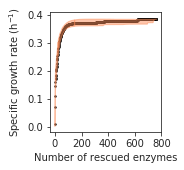

In [109]:
plot_growth_rate_when_removing_temp_constraints_BS('../results/sequentially_remove_temperature_constraints_ind_BS_all_particles.pkl')

In [22]:
def plot_ensemble_results(infile,sg=0.3,votes=50):
    plt.figure(figsize=(5.5,2.2))
    sns.set_style('white')
    results = pickle.load(open(infile,'rb'))
    annots = load_pathway_annotation()
    gene_names,gene_ids = load_gene_names()
    
    # select succefully finished particles
    top_enzs = dict()
    particles = 0
    required_num = []
    for i,lst in enumerate(results[0]):
        if len(lst)<764: continue
        if np.max(lst)>1: continue
        particles += 1
        for j,r in enumerate(lst):
            enz = results[1][i][j].split('_')[1]
            name = gene_names[enz]
            if r <= sg: top_enzs[name] = top_enzs.get(name,0) + 1
            else: 
                required_num.append(j)
                break
    print('On averge requres {} enzymes to be rescued'.format(np.mean(required_num)))
    lst = [(v/particles*100,k) for k,v in top_enzs.items()]
    lst.sort(reverse=True)
    print(len(lst))
    print(lst)
    inds = [item[1] for item in lst]
    vals = [item[0] for item in lst]
    df_top = pd.DataFrame(data={'vote_percentage':vals},index=inds)
    df_top.to_csv('../results/figure5e_all_enzymes.csv')
    
    # plot all

    plt.figure(figsize=(5.5,2.2))
    sns.set_style('white')
    x = [item[0] for item in lst]
    plt.bar(np.arange(len(x)),x,color='gray',width=1) #fc8d59
    plt.xticks(np.arange(0,len(x),10),np.arange(0,len(x),10))

    plt.ylabel('Percentage of models (%)')
    plt.xlim(-0.7,len(x)-0.3)
    plt.xlabel('{0} enzymes'.format(len(x)))
    #plt.tight_layout()
    plt.savefig('../figures/voted_enzymes_all_BS_{0}.pdf'.format(sg),bbox_inches='tight',transparent=True)
    plt.show()
    
    
    plt.figure(figsize=(5.5,2.2))
    colors = '''#e7298a
    #1b9e77
    #66a61e
    #d95f02
    #7570b3
    #e6ab02'''.split()

    print(colors)
    sel_num = len([item for item in lst if item[0]>=votes])
    print(sel_num,'number of enzymes >50%')
    x = [item[0] for item in lst][:sel_num]
    names = [item[1] for item in lst][:sel_num]
    pathways = [annots[names[i]].split()[1] for i  in range(sel_num)]
    pathways = np.array(pathways)
    pathways[pathways=='Terpenoid'] = 'Sterol'
    pathways[pathways=='Steroid'] = 'Sterol'
    pathways[pathways=='Alanine,'] = 'Amino acids'
    pathways[pathways=='Lysine'] = 'Amino acids'
    pathways[pathways=='Cysteine'] = 'Amino acids'
    pathways[pathways=='Porphyrin'] = 'Aminoacyl-tRNA'
    
    print(len(set(pathways)))
    print(set(pathways))
    #c_dct = {list(set(pathways))[i]: colors[i] for i in range(len(set(pathways)))}
    c_dct = {list(set(pathways))[i]: cm.tab10((i+1)*0.9/len(set(pathways))) for i in range(len(set(pathways)))}
    c_lst = [c_dct[p] for p in pathways]
    for i in range(sel_num):
        print(names[i],x[i],annots[names[i]])

    for k,v in c_dct.items(): 
        plt.bar(0,0,color=v,label=k)
    plt.bar(np.arange(len(x)),x,color=c_lst)
    plt.xticks(np.arange(len(x)),names,rotation=90,fontsize=8)

    plt.ylabel('Percentage of models (%)')
    plt.xlim(-0.7,len(x)-0.3)
    plt.legend(ncol=2,fontsize=8)
    #plt.tight_layout()
    plt.savefig('../figures/voted_enzymes_BS_{0}.pdf'.format(sg),bbox_inches='tight',transparent=True)
    plt.show()

    

/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


On averge requres 10.032608695652174 enzymes to be rescued
82
[(98.91304347826086, 'ERG1'), (84.78260869565217, 'TDH1'), (79.34782608695652, 'TDH3'), (77.17391304347827, 'TDH2'), (57.608695652173914, 'PDC1'), (41.30434782608695, 'TAL1'), (39.130434782608695, 'PDC6'), (36.95652173913043, 'FBA1'), (34.78260869565217, 'ENO1'), (33.69565217391305, 'HMG1'), (31.521739130434785, 'ALA1'), (25.0, 'HMG2'), (20.652173913043477, 'PDC5'), (18.478260869565215, 'CDC60'), (17.391304347826086, 'PFK2'), (17.391304347826086, 'KRS1'), (17.391304347826086, 'GUA1'), (15.217391304347828, 'GRS2'), (14.130434782608695, 'GPM1'), (13.043478260869565, 'ENO2'), (11.956521739130435, 'DPS1'), (10.869565217391305, 'PGK1'), (10.869565217391305, 'LYS21'), (10.869565217391305, 'ADE5'), (9.782608695652174, 'YHR020W'), (8.695652173913043, 'TPS2'), (8.695652173913043, 'PFK1'), (8.695652173913043, 'OLE1'), (8.695652173913043, 'ARO2'), (7.608695652173914, 'HIS4'), (7.608695652173914, 'GRS1'), (6.521739130434782, 'MET14'), (

<Figure size 396x158.4 with 0 Axes>

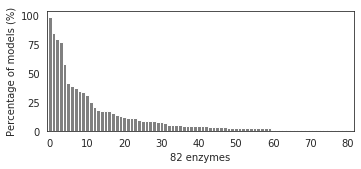

['#e7298a', '#1b9e77', '#66a61e', '#d95f02', '#7570b3', '#e6ab02']
24 number of enzymes >50%
6
{'Glycolysis', 'Purine', 'Sterol', 'Amino acids', 'Pentose', 'Aminoacyl-tRNA'}
ERG1 98.91304347826086 sce00100  Steroid biosynthesis sce00909  Sesquiterpenoid and triterpenoid biosynthesis sce01110  Biosynthesis of secondary metabolites
TDH1 84.78260869565217 sce00010  Glycolysis / Gluconeogenesis sce01110  Biosynthesis of secondary metabolites sce01200  Carbon metabolism sce01230  Biosynthesis of amino acids
TDH3 79.34782608695652 sce00010  Glycolysis / Gluconeogenesis sce01110  Biosynthesis of secondary metabolites sce01200  Carbon metabolism sce01230  Biosynthesis of amino acids
TDH2 77.17391304347827 sce00010  Glycolysis / Gluconeogenesis sce01110  Biosynthesis of secondary metabolites sce01200  Carbon metabolism sce01230  Biosynthesis of amino acids
PDC1 57.608695652173914 sce00010  Glycolysis / Gluconeogenesis sce01110  Biosynthesis of secondary metabolites
TAL1 41.30434782608695 sce000

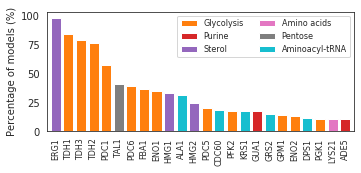

In [23]:
plot_ensemble_results('../results/sequentially_remove_temperature_constraints_ind_BS_all_particles.pkl',0.2,10)

In [24]:
!head ../results/figure5e_all_enzymes.csv

,vote_percentage
ERG1,98.91304347826086
TDH1,84.78260869565217
TDH3,79.34782608695652
TDH2,77.17391304347827
PDC1,57.608695652173914
TAL1,41.30434782608695
PDC6,39.130434782608695
FBA1,36.95652173913043
ENO1,34.78260869565217
